In [1]:
# def save_log(file_name, log, mode='a', path = './checkpoint/'):
#     with open(path+file_name, mode) as f:
#         if mode == 'a':
#             f.write('\n')
#         if type(log) is str:
#             f.write(log)
#             print(log)
#         else:
#             log = [str(l) for l in log]
#             f.write(' '.join(log))
#             print(' '.join(log))

# save_log('test.txt', ['I like',100,'l'], 'a')

In [2]:
import os
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader, random_split
import torchaudio
from pypinyin import lazy_pinyin, Style

In [3]:
bundle = torchaudio.pipelines.WAV2VEC2_XLSR53
wave2vec_model = bundle.get_model()

In [4]:
# wave2vec_model

In [5]:
k_size = wave2vec_model.feature_extractor.conv_layers[0].conv.kernel_size[0]

In [6]:
wave2vec_model.encoder.transformer.layers[-1].final_layer_norm.normalized_shape[0]

1024

In [7]:
class ChineseStt(torch.nn.Module):
    def __init__(self, wave2vec_model, out_features):
        super(ChineseStt, self).__init__()
        self.feature_extractor = wave2vec_model.feature_extractor
        self.encoder = wave2vec_model.encoder
        in_features = wave2vec_model.encoder.transformer.layers[-1].final_layer_norm.normalized_shape[0]
        self.aux = nn.Linear(in_features, out_features, bias=True)

    def forward(self, x, lengths=None):
        x, lengths = self.feature_extractor(x, lengths)
        x = self.encoder(x, lengths)
        x = self.aux(x)
        return x, lengths

chineseStt = ChineseStt(wave2vec_model, 10)

In [8]:
chineseStt

ChineseStt(
  (feature_extractor): FeatureExtractor(
    (conv_layers): ModuleList(
      (0): ConvLayerBlock(
        (layer_norm): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
        (conv): Conv1d(1, 512, kernel_size=(10,), stride=(5,))
      )
      (1): ConvLayerBlock(
        (layer_norm): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
        (conv): Conv1d(512, 512, kernel_size=(3,), stride=(2,))
      )
      (2): ConvLayerBlock(
        (layer_norm): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
        (conv): Conv1d(512, 512, kernel_size=(3,), stride=(2,))
      )
      (3): ConvLayerBlock(
        (layer_norm): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
        (conv): Conv1d(512, 512, kernel_size=(3,), stride=(2,))
      )
      (4): ConvLayerBlock(
        (layer_norm): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
        (conv): Conv1d(512, 512, kernel_size=(3,), stride=(2,))
      )
      (5): ConvLayerBlock(
        (layer_

In [9]:
import requests
SPEECH_URL = "https://download.pytorch.org/torchaudio/tutorial-assets/Lab41-SRI-VOiCES-src-sp0307-ch127535-sg0042.wav"
SPEECH_FILE = "_assets/speech.wav"

if not os.path.exists(SPEECH_FILE):
    os.makedirs("_assets", exist_ok=True)
    with open(SPEECH_FILE, "wb") as file:
        file.write(requests.get(SPEECH_URL).content)

In [10]:

with torch.inference_mode():
    waveform, _ = torchaudio.load(SPEECH_FILE)
    print(waveform.shape)
    emissions, _ = chineseStt(waveform)
    emissions = torch.log_softmax(emissions, dim=-1)

emission = emissions[0].cpu().detach()

torch.Size([1, 54400])


In [119]:
from pypinyin import lazy_pinyin, Style


def chinese2pinyin(text):
    pinyin = lazy_pinyin(text, strict=True,errors=lambda x: u'')
    pinyin = [i for i in '|'.join(pinyin)]
    return pinyin

In [12]:
import sys
from utils.dataset import AudioDataset, LoaderGenerator
import importlib
importlib.reload(sys.modules['utils.dataset'])


<module 'utils.dataset' from '/scratch/bh2283/code/utils/dataset.py'>

In [94]:
from utils.helper import get_labels
labels = get_labels()

In [14]:
dataset = AudioDataset('./data/ST-CMDS-20170001_1-OS/')
train_set, test_set = dataset.split([8, 2])
loaderGenerator = LoaderGenerator(labels, chinese2pinyin, k_size)
train_loader = loaderGenerator.dataloader(train_set, 8)
test_loader = loaderGenerator.dataloader(test_set, 8)
for data in test_loader:
    print(data['audio'].shape, data['target'].shape)
    break

torch.Size([8, 78600]) torch.Size([8, 57])


In [15]:
from utils.textDecoder import GreedyCTCDecoder, NaiveDecoder

In [16]:
mean = lambda x: sum(x)/len(x)
mean([1,2,3])

2.0

In [111]:
import os
import torch
from torch.utils.data import Dataset, DataLoader, random_split
import torchaudio

from utils.dataset import AudioDataset, LoaderGenerator
importlib.reload(sys.modules['utils.dataset'])

dataset = AudioDataset('./data/ST-CMDS-20170001_1-OS/')
print(len(dataset))

102600


In [106]:
path = './data/cv-corpus-8.0-2022-01-19/zh-CN/'
!ls ./data/cv-corpus-8.0-2022-01-19/zh-CN

clips	 invalidated.tsv  reported.tsv	train.tsv
dev.tsv  other.tsv	  test.tsv	validated.tsv


In [40]:
files = os.listdir(path+'clips')
len(files)

65479

In [66]:
import pandas as pd

df1 = pd.read_csv(path+'other.tsv',sep='\t')
df1.head(3)

,client_id,path,sentence,up_votes,down_votes,age,gender,accents,locale,segment
0,25bc975d06200b7b1c9135db090561cb0d9b28d172e51c...,common_voice_zh-CN_19703883.mp3,模式种采样自台湾龟山岛。,1,0,thirties,female,出生地：31 上海市,zh-CN,NaN
1,25bc975d06200b7b1c9135db090561cb0d9b28d172e51c...,common_voice_zh-CN_19706151.mp3,后者娶天之瓮主神。,1,0,thirties,female,出生地：31 上海市,zh-CN,NaN
2,faa0ecc626e80638016d6295b5018372b8567f5f3177f6...,common_voice_zh-CN_19961025.mp3,贝尔卢。,1,0,twenties,male,出生地：32 江苏省,zh-CN,NaN


In [67]:
df1 = pd.read_csv(path+'validated.tsv',sep='\t')
df2 = pd.read_csv(path+'invalidated.tsv',sep='\t')
df3 = pd.read_csv(path+'other.tsv',sep='\t')
print(len(df1),len(df2),len(df3))
len(set(df1.path.to_list()+df2.path.to_list()+df3.path.to_list()))

46743 6424 12312


65479

In [68]:
# df1.path.to_list()

In [69]:
df1 = pd.read_csv(path+'validated.tsv',sep='\t')[['path', 'sentence']]
df2 = pd.read_csv(path+'invalidated.tsv',sep='\t')[['path', 'sentence']]
df3 = pd.read_csv(path+'other.tsv',sep='\t')[['path', 'sentence']]
df = pd.concat([df1, df2, df3])

df.head()

,path,sentence
0,common_voice_zh-CN_22069600.mp3,宋朝末年年间定居粉岭围。
1,common_voice_zh-CN_22006851.mp3,渐渐行动不便
2,common_voice_zh-CN_22115132.mp3,二十一年去世。
3,common_voice_zh-CN_22120171.mp3,他们自称恰哈拉。
4,common_voice_zh-CN_18646658.mp3,局部干涩的例子包括有口干、眼睛干燥、及阴道干燥。


In [70]:
audio_path = df['path']
sentence_text = df['sentence']
len(audio_path), len(df)

(65479, 65479)

In [80]:
audio_path

0        common_voice_zh-CN_22069600.mp3
1        common_voice_zh-CN_22006851.mp3
2        common_voice_zh-CN_22115132.mp3
3        common_voice_zh-CN_22120171.mp3
4        common_voice_zh-CN_18646658.mp3
                      ...               
12307    common_voice_zh-CN_30532477.mp3
12308    common_voice_zh-CN_30532478.mp3
12309    common_voice_zh-CN_30532479.mp3
12310    common_voice_zh-CN_30532481.mp3
12311    common_voice_zh-CN_30532480.mp3
Name: path, Length: 65479, dtype: object

In [121]:
import pandas as pd

class CvCorpus8Dataset(Dataset):

    def __init__(self, data_path, sample_rate=16000, transform=None):
        df1 = pd.read_csv(path+'validated.tsv',sep='\t')[['path', 'sentence']]
        df2 = pd.read_csv(path+'invalidated.tsv',sep='\t')[['path', 'sentence']]
        df3 = pd.read_csv(path+'other.tsv',sep='\t')[['path', 'sentence']]
        df = pd.concat([df1, df2, df3])
        audio_path = df['path'].to_list()
        sentence_text = df['sentence'].to_list()
        assert len(audio_path) == len(sentence_text)
        self.audio_path = audio_path
        self.sentence_text = sentence_text
        self.size = len(audio_path)
        self.data_path = data_path
        self.transform = transform
        self.sample_rate = sample_rate
        self.threshold = 170000 # to avoid GPU memory used out
        self.batch_size = 64 # to avoid GPU memory used out

    def __len__(self):
        return len(self.audio_path)

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()

        audio_name = self.get_audio(idx)
        waveform, sample_rate = torchaudio.load(audio_name)
        waveform = waveform
        if sample_rate != self.sample_rate:
            waveform = torchaudio.functional.resample(waveform, sample_rate, self.sample_rate)
        audio_content = self.get_text(idx)
        sample = {'audio': waveform, 'text': audio_content}
        if self.transform:
            sample = self.transform(sample)
        return sample

    def get_audio(self, x): 
        return self.data_path+'clips/'+self.audio_path[x] if x < len(self) else None
        
    def get_text(self, x): 
        return self.sentence_text[x] if x < len(self) else None
    
    def split(self, split_ratio=[8, 2], seed=42):
        lengths = [(i*len(self))//sum(split_ratio) for i in split_ratio]
        lengths[-1] = len(self) - sum(lengths[:-1])
        split_dataset = random_split(self, lengths, generator=torch.Generator().manual_seed(seed))
        return split_dataset

cvCorpus8Dataset = CvCorpus8Dataset('./data/cv-corpus-8.0-2022-01-19/zh-CN/')
train_set, test_set = cvCorpus8Dataset.split([1000, 5])
loaderGenerator = LoaderGenerator(labels, chinese2pinyin, k_size)
batch_size = 8
train_loader = loaderGenerator.dataloader(train_set, batch_size)
test_loader = loaderGenerator.dataloader(test_set, batch_size)
len(cvCorpus8Dataset), len(train_set), len(test_set)

(65479, 65153, 326)

In [123]:
torchaudio.save('audio-temp.wav', test_set[2]['audio'], 16000)
test_set[2].decode('utf-8')

AttributeError: 'dict' object has no attribute 'decode'

In [ ]:
def test(k):
    model.eval()
    with torch.no_grad():
        for i in range(k):
            sample = test_set[i]
            print(i, sample['audio'].shape, sample['text'])
            waveform = sample['audio']
            emissions, _ = model(waveform.to(device))
            emissions = torch.log_softmax(emissions, dim=-1)
            emission = emissions[0].cpu().detach()
            transcript = decoder(emission)
            print('transcript:', transcript, NaiveCTCDecoder(labels)(emission))

In [114]:
def id2label(idcs):
    return [labels[i] for i in idcs]

In [117]:
for data in train_loader:
    print(data['audio'].shape)
    torchaudio.save('audio-temp.wav', data['audio'][0].unsqueeze(0), 16000)
    print(data['target'][0])
    print(''.join(id2label(data['target'][0])))
    break

torch.Size([8, 161269])
tensor([19, 14,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
         0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
         0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
         0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
         0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
         0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
         0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
         0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0])
wu----------------------------------------------------------------------------------------------------------------------------------------------


In [28]:
def chinese2pinyin(text):
    pinyin = lazy_pinyin(text, strict=True,errors=lambda x: u'')
    pinyin = [i for i in '|'.join(pinyin)]
    return pinyin

text = cvCorpus8Dataset[0]['text']
text, ''.join(chinese2pinyin(text))

('模式种采样自台湾龟山岛。', 'mo|shi|zhong|cai|yang|zi|tai|wan|gui|shan|dao')

In [ ]:
lens = [train_set[i]['audio'].shape[1] for i in range(800)]

In [27]:
lens2 = [train_set[i+800]['audio'].shape[1] for i in range(800)]

In [42]:
lens3 = [train_set[i+8000]['audio'].shape[1] for i in range(800)]

In [52]:
lens4 = [train_set[i+10000]['audio'].shape[1] for i in range(800)]

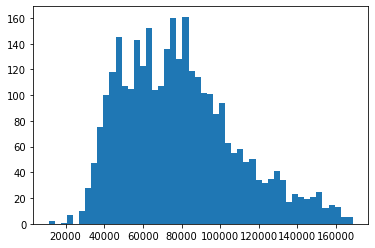

In [53]:
import matplotlib.pyplot as plt
plt.hist(lens+lens2+lens3+lens4, bins = 50)
plt.show()

In [24]:
batch_size = 80
k_size = 10 # kernel size for audio encoder
from pypinyin import lazy_pinyin
def chinese2pinyin(text):
    pinyin = lazy_pinyin(text, strict=True,errors=lambda x: u'')
    pinyin = [i for i in '|'.join(pinyin)]
    return pinyin
from utils.helper import get_labels
labels = get_labels()
loaderGenerator = LoaderGenerator(labels, chinese2pinyin, k_size)
train_loader = loaderGenerator.dataloader(train_set, batch_size)
test_loader = loaderGenerator.dataloader(test_set, batch_size) # without backprop, can use larger batch
print('train_set:', len(train_set), 'test_set:',len(test_set))
steps = 3
for i_batch, sample_batched in enumerate(train_loader):
    print(sample_batched['audio'].shape, sample_batched['target'].shape)
    # for i in sample_batched['audio']:
    #     print(i.shape)
    if steps < 0:
        break
    steps -= 1

train_set: 12250 test_set: 62
torch.Size([80, 162040]) torch.Size([80, 138])
torch.Size([80, 158200]) torch.Size([80, 270])
torch.Size([80, 157818]) torch.Size([80, 116])
torch.Size([80, 161277]) torch.Size([80, 115])
torch.Size([80, 162430]) torch.Size([80, 140])
